In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Задание 

1. Сформировать с помощью sklearn.make_classification датасет из 1000 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).
2. Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.
3. *Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

In [2]:
import numpy as np
import random

from matplotlib import pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap

In [3]:
n_samples = 1000
n_features = 2
data, labels = make_classification(n_samples=n_samples, n_features=n_features, n_informative=2, n_redundant=0,
                                   n_classes=2)

In [4]:
train_data, test_data, train_labels, test_labels = train_test_split(data, 
                                                                    labels, 
                                                                    test_size = 0.3,
                                                                    random_state = 1)

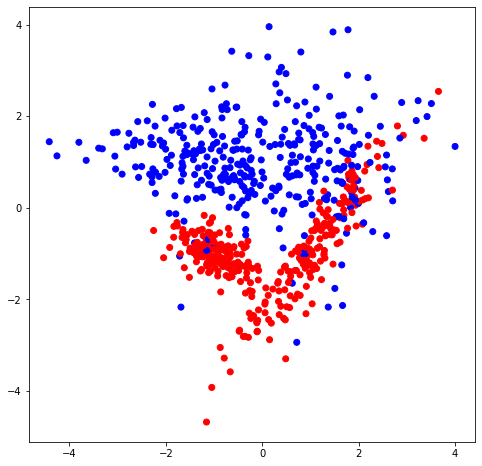

In [5]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], train_data)), list(map(lambda x: x[1], train_data)), 
              c=train_labels, cmap=colors)
plt.show()

Далее реализуем построение дререва решений:

In [6]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [7]:
# а также класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction 

In [8]:
# Расчитываем критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [9]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выброки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [10]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [11]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1] - 1
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [12]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [13]:
random.seed(42)
# Генерация bootstrap выборок
def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [14]:
def get_subsample(len_sample):
    # теперь сохраняем индексы, а не сами признаки: 
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [15]:
# формирование случайного леса
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [16]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [17]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [18]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions


In [19]:
train_data.shape

(700, 2)

In [20]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [21]:
n_trees1 = 1
n_trees3 = 3
n_trees10 = 10
n_trees50 = 50
n_trees100 = 100

In [22]:
my_forest1 = random_forest(train_data, train_labels, n_trees1)
train_answers1 = tree_vote(my_forest1, train_data)
test_answers1 = tree_vote(my_forest1, test_data)
train_acc1 = accuracy_metric(train_labels, train_answers1)
print(f'Точность случайного леса из {n_trees1} деревьев на обучающей выборке: {train_acc1:.3f}')
test_acc1 = accuracy_metric(test_labels, test_answers1)
print(f'Точность случайного леса из {n_trees1} деревьев на тестовой выборке: {test_acc1:.3f}')

Точность случайного леса из 1 деревьев на обучающей выборке: 83.429
Точность случайного леса из 1 деревьев на тестовой выборке: 55.333


In [23]:
my_forest3 = random_forest(train_data, train_labels, n_trees3)
train_answers3 = tree_vote(my_forest3, train_data)
test_answers3 = tree_vote(my_forest3, test_data)
train_acc3 = accuracy_metric(train_labels, train_answers3)
print(f'Точность случайного леса из {n_trees3} деревьев на обучающей выборке: {train_acc3:.3f}')
test_acc3 = accuracy_metric(test_labels, test_answers3)
print(f'Точность случайного леса из {n_trees3} деревьев на тестовой выборке: {test_acc3:.3f}')

Точность случайного леса из 3 деревьев на обучающей выборке: 90.143
Точность случайного леса из 3 деревьев на тестовой выборке: 59.333


In [24]:
my_forest10 = random_forest(train_data, train_labels, n_trees10)
train_answers10 = tree_vote(my_forest10, train_data)
test_answers10 = tree_vote(my_forest10, test_data)
train_acc10 = accuracy_metric(train_labels, train_answers10)
print(f'Точность случайного леса из {n_trees10} деревьев на обучающей выборке: {train_acc10:.3f}')
test_acc10 = accuracy_metric(test_labels, test_answers10)
print(f'Точность случайного леса из {n_trees10} деревьев на тестовой выборке: {test_acc10:.3f}')

Точность случайного леса из 10 деревьев на обучающей выборке: 96.000
Точность случайного леса из 10 деревьев на тестовой выборке: 58.667


In [25]:
my_forest50 = random_forest(train_data, train_labels, n_trees50)
train_answers50 = tree_vote(my_forest50, train_data)
test_answers50 = tree_vote(my_forest50, test_data)
train_acc50 = accuracy_metric(train_labels, train_answers50)
print(f'Точность случайного леса из {n_trees50} деревьев на обучающей выборке: {train_acc50:.3f}')
test_acc50 = accuracy_metric(test_labels, test_answers50)
print(f'Точность случайного леса из {n_trees50} деревьев на тестовой выборке: {test_acc50:.3f}')

Точность случайного леса из 50 деревьев на обучающей выборке: 99.143
Точность случайного леса из 50 деревьев на тестовой выборке: 58.333


In [26]:
my_forest100 = random_forest(train_data, train_labels, n_trees100)
train_answers100 = tree_vote(my_forest100, train_data)
test_answers100 = tree_vote(my_forest100, test_data)
train_acc100 = accuracy_metric(train_labels, train_answers100)
print(f'Точность случайного леса из {n_trees100} деревьев на обучающей выборке: {train_acc100:.3f}')
test_acc100 = accuracy_metric(test_labels, test_answers100)
print(f'Точность случайного леса из {n_trees100} деревьев на тестовой выборке: {test_acc100:.3f}')

Точность случайного леса из 100 деревьев на обучающей выборке: 100.000
Точность случайного леса из 100 деревьев на тестовой выборке: 58.333


In [27]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.1, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    xx,yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step)) 
    x = xx.reshape(-1,1)
    y = yy.reshape(-1,1)
    f = np.ones((x.shape[0],data[:, 2:].shape[1]))
    print(f.shape,x.shape,y.shape)
    data_gr = np.concatenate((x,y,f),axis=1)
    return xx,yy , data_gr# список массивов координатных сеток

(12099, 0) (12099, 1) (12099, 1)


Text(0.5, 1.0, 'Test accuracy=55.33')

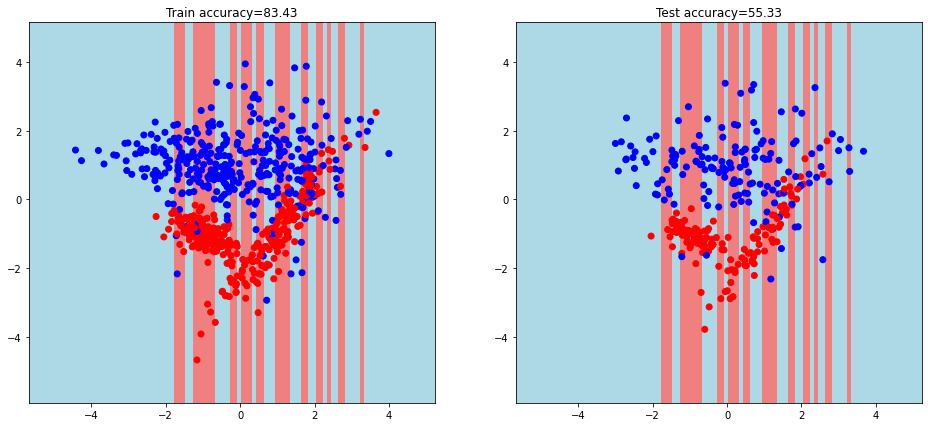

In [28]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy,gr = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest1,gr)).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_acc1:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_acc1:.2f}')

(12099, 0) (12099, 1) (12099, 1)


Text(0.5, 1.0, 'Test accuracy=59.33')

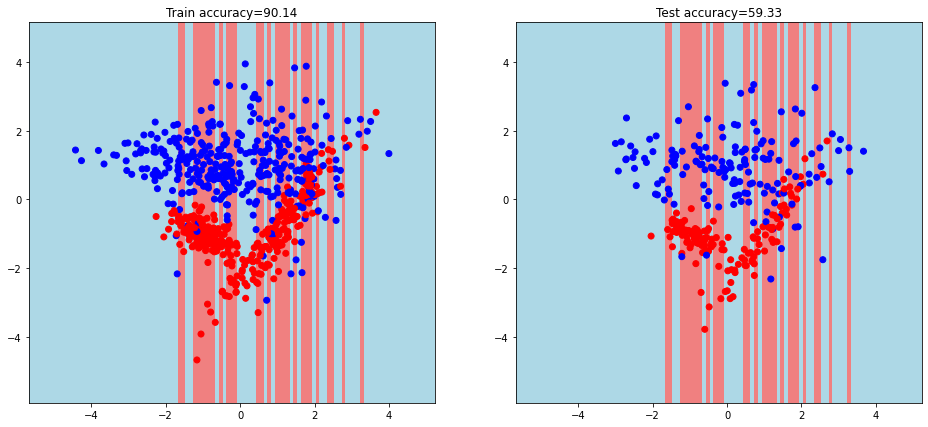

In [29]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy,gr = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote( my_forest3,gr)).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_acc3:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_acc3:.2f}')

(12099, 0) (12099, 1) (12099, 1)


Text(0.5, 1.0, 'Test accuracy=58.67')

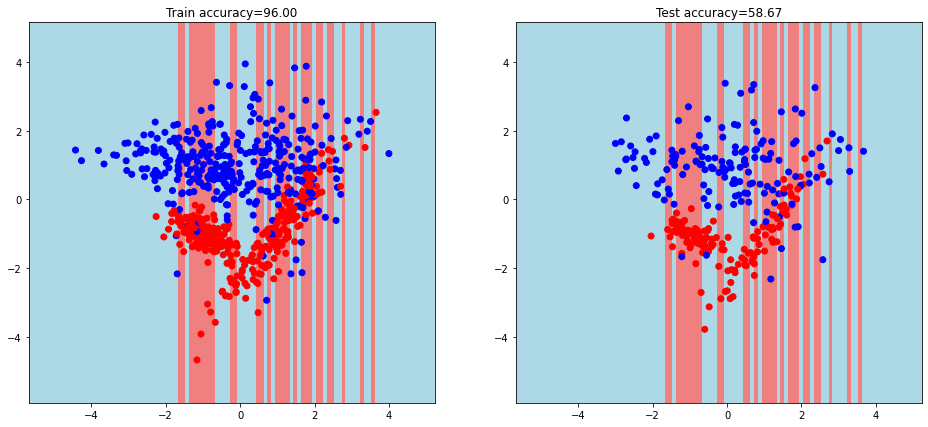

In [30]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy,gr = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote( my_forest10,gr)).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_acc10:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_acc10:.2f}')

(12099, 0) (12099, 1) (12099, 1)


Text(0.5, 1.0, 'Test accuracy=58.33')

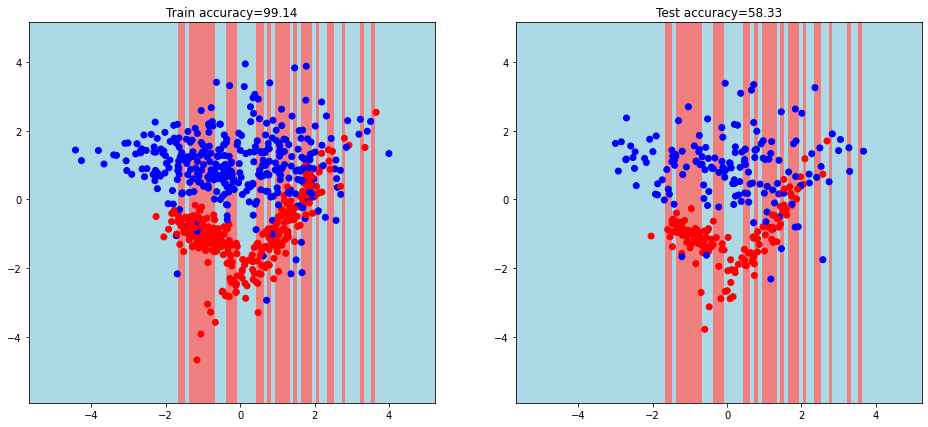

In [31]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy,gr = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote( my_forest50,gr)).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_acc50:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_acc50:.2f}')

(12099, 0) (12099, 1) (12099, 1)


Text(0.5, 1.0, 'Test accuracy=58.33')

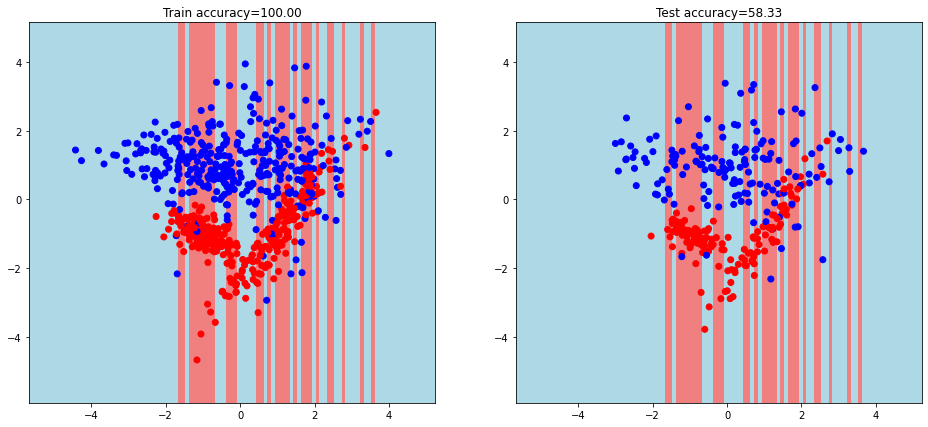

In [32]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy,gr = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote( my_forest100,gr)).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_acc100:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_acc100:.2f}')

**2 Выводы**

Точность случайного леса возрастает с ростом числа дерервьев в нём, при этом модель не переобучается при увеличении числа базовых алгоритмов. По условию задачи мы использовали два признака, увеличение числа признаков могло бы повысить точность нашей модели.

**3.** *Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

In [33]:
def get_bootstrap_oob(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    oob = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        indexes = []
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            indexes.append(sample_index)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
        oob_indexes = [i for i in range(n_samples) if i not in set(indexes)]
        oob_data = data[oob_indexes]
        oob_labels = labels[oob_indexes]
        oob.append((oob_data, oob_labels))
    return bootstrap, oob

In [34]:
def calc_oob_acc(oob, tree):
    oob_answers = predict(oob[0], tree)
    oob_acc = accuracy_metric(oob[1], oob_answers)
    return oob_acc

In [35]:
def random_forest_oob(data, labels, n_trees):
    forest = []
    bootstrap, oob = get_bootstrap_oob(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
    
    oob_acc = 0
    for i in range(n_trees):
        oob_acc += calc_oob_acc(oob[i], forest[i])
    oob_result = oob_acc / n_trees
    return forest, oob_result

In [36]:
forest, oob = random_forest_oob(data=data, labels=labels, n_trees=50)

In [37]:
print(f'OOB Score: {oob:.3f}')

OOB Score: 53.069


In [38]:
from sklearn.ensemble import RandomForestClassifier

In [39]:
model = RandomForestClassifier(n_estimators=50, oob_score=True)

In [40]:
forest = model.fit(data, labels)

In [41]:
print(f'OOB Score: {forest.oob_score_ * 100:.3f}')

OOB Score: 90.700
